In [1]:
import torch
import gym
import time
import numpy as np
import importlib
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
import hedging_gym, asset_price_models, option_price_models, dqn_utils
_ = importlib.reload(hedging_gym)
_ = importlib.reload(asset_price_models)
_ = importlib.reload(option_price_models)
_ = importlib.reload(dqn_utils)

from hedging_gym import HedgingEnv
from asset_price_models import GBM
from option_price_models import BSM
from dqn_utils import predict_while_training, predict_while_testing
from dqn_utils import add_to_training_set, train, create_dqn

In [3]:
np.random.seed(0)
torch.manual_seed(0)

# option model paramaters
strike_price             = 100
rf_interest_rate         = 0.01
T                        = 1.0

# asset model parameters
mu                       = 0
vol                      = 0.15
dt                       = T / 128
S_0                      = 100

# hedging gym parameters
max_steps                = 100
option_contracts         = 20
initial_holding_fraction = 0.5
trading_cost_parameter   = 0.001
trading_cost_gradient    = 0.0

# DQN parameters
num_hidden               = 1
hidden_dim               = 20
discount                 = 0.8
epsilon_decay            = 0.99
learning_rate            = 0.1

asset_price_model  = GBM(mu, vol, S_0, dt)
option_price_model = BSM(strike_price, rf_interest_rate, vol, T, dt)
env                = HedgingEnv(asset_price_model, option_price_model, max_steps, option_contracts,
                                initial_holding_fraction, trading_cost_parameter, trading_cost_gradient)
dqn                = create_dqn(num_hidden, hidden_dim, discount, epsilon_decay, learning_rate, env)

In [4]:
def run_comparison(dqn, env, num_runs=100):
    rows = {
        'rl':    [],
        'delta': []
    }
        
    for mode in rows.keys():
        for run in range(num_runs):
            np.random.seed(run)
            done  = False
            state = env.reset()

            hedging_pnls = []
            trading_pnls = []
            rewards      = []

            while not done:
                if mode == 'delta':
                    new_h                 = round(env.option_delta() * env.OCS)
                    new_state, pnls, done = env.step(new_h)
                elif mode == 'rl':
                    new_h                 = predict_while_testing(dqn, state)
                    new_state, pnls, done = env.step(new_h.item())
                else:
                    assert False
                    
                reward                = (0.0005*np.sum(pnls) - np.sum(pnls)**2)
                state                 = new_state

                hedging_pnls.append(pnls[0])
                trading_pnls.append(pnls[1])
                rewards.append(reward)

            rows[mode].append({
                    'hedging_pnl' : np.sum(hedging_pnls),
                    'hedging_std' : np.std(hedging_pnls),
                    'trading_pnl' : np.sum(trading_pnls),
                    'reward'      : np.sum(rewards)   
            })
    
    for mode in rows.keys():
        rows[mode] = pd.DataFrame(rows[mode])
    return rows

def interpret_rows(rows):
    num_metrics = len(rows['rl'].columns)

    fig, axs = plt.subplots(1, num_metrics)
    fig.set_size_inches(5 * num_metrics, 5)

    for i, metric in enumerate(rows['rl'].columns):
        rows['rl'][metric].hist(bins=10, ax=axs[i])
        rows['delta'][metric].hist(bins=10, ax=axs[i])
        axs[i].set_title(metric)

    display(rows['rl'].describe(percentiles=[]).join(rows['delta'].describe(percentiles=[]), lsuffix="_rl", rsuffix="_delta"))    
    plt.show()

,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.006650,0.336893,-3.000000e-05,-0.134295,-0.003877,0.038168,-0.000560,-0.001586
std,0.033715,0.140794,4.767281e-20,0.104781,0.004115,0.009547,0.000142,0.000787
min,-0.036910,0.089525,-3.000000e-05,-0.438221,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.018894,0.311252,-3.000000e-05,-0.097033,-0.003721,0.037633,-0.000565,-0.001462
max,0.116939,0.651616,-3.000000e-05,-0.009004,0.007877,0.066245,-0.000220,-0.000368


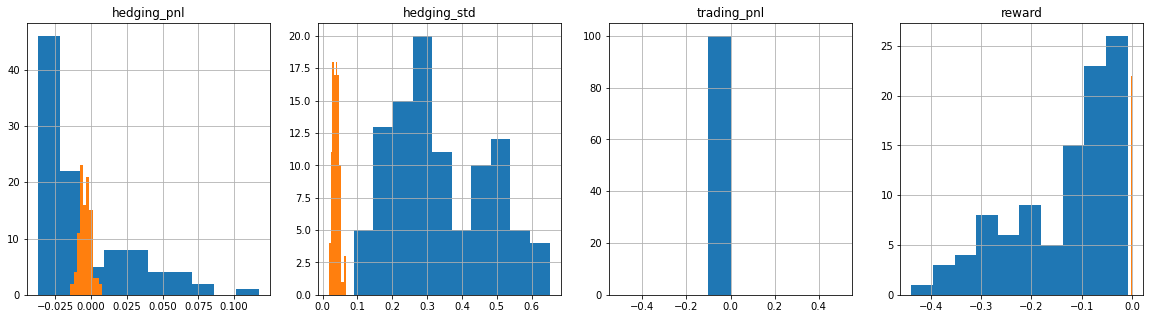

processing episode 0


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.006650,0.336893,-3.000000e-05,-0.134295,-0.003877,0.038168,-0.000560,-0.001586
std,0.033715,0.140794,4.767281e-20,0.104781,0.004115,0.009547,0.000142,0.000787
min,-0.036910,0.089525,-3.000000e-05,-0.438221,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.018894,0.311252,-3.000000e-05,-0.097033,-0.003721,0.037633,-0.000565,-0.001462
max,0.116939,0.651616,-3.000000e-05,-0.009004,0.007877,0.066245,-0.000220,-0.000368


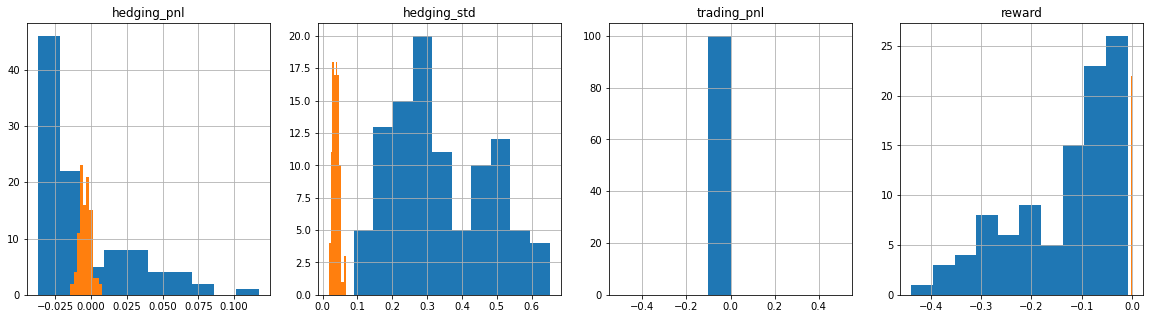

processing episode 100


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.005182,0.242148,-0.000596,-0.067141,-0.003877,0.038168,-0.000560,-0.001586
std,0.026207,0.088721,0.000289,0.047208,0.004115,0.009547,0.000142,0.000787
min,-0.042221,0.088051,-0.001330,-0.210198,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.013044,0.216685,-0.000600,-0.047061,-0.003721,0.037633,-0.000565,-0.001462
max,0.083305,0.450988,-0.000060,-0.009377,0.007877,0.066245,-0.000220,-0.000368


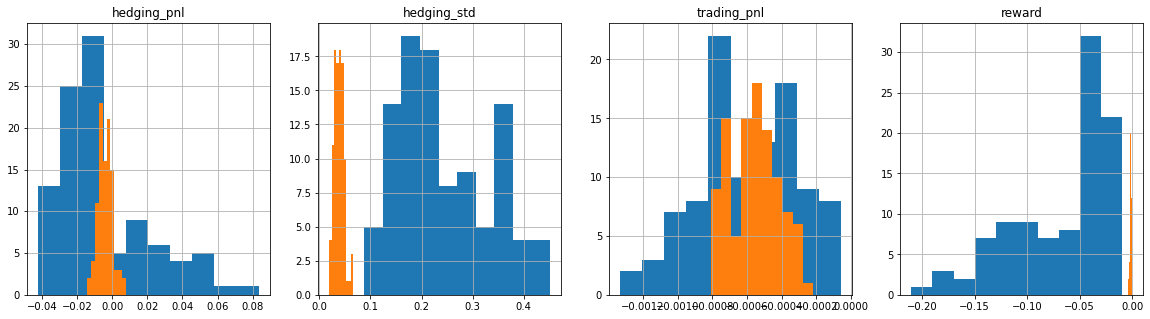

processing episode 200


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.003741,0.156245,-0.001619,-0.025641,-0.003877,0.038168,-0.000560,-0.001586
std,0.015512,0.031165,0.000834,0.009882,0.004115,0.009547,0.000142,0.000787
min,-0.036538,0.091975,-0.003550,-0.057681,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.003973,0.157497,-0.001530,-0.025044,-0.003721,0.037633,-0.000565,-0.001462
max,0.032007,0.238473,-0.000350,-0.008830,0.007877,0.066245,-0.000220,-0.000368


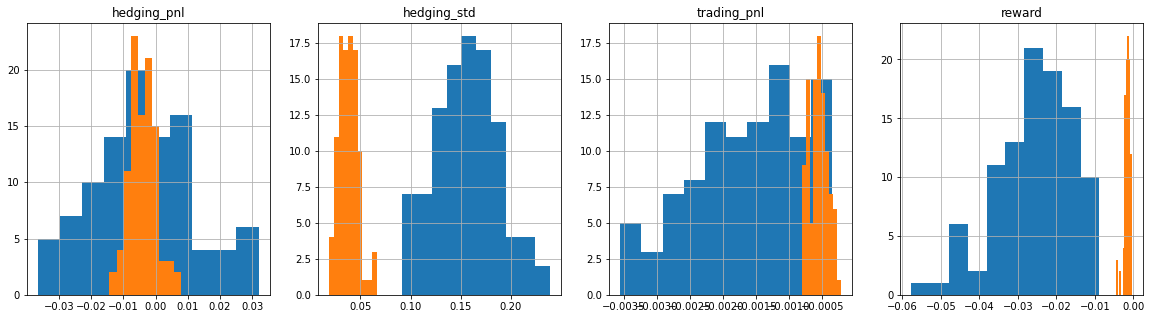

processing episode 300


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.004172,0.183355,-0.000638,-0.036598,-0.003877,0.038168,-0.000560,-0.001586
std,0.015416,0.052185,0.000408,0.020124,0.004115,0.009547,0.000142,0.000787
min,-0.032531,0.095407,-0.001710,-0.096310,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.005106,0.172114,-0.000545,-0.029717,-0.003721,0.037633,-0.000565,-0.001462
max,0.046785,0.308781,-0.000110,-0.009530,0.007877,0.066245,-0.000220,-0.000368


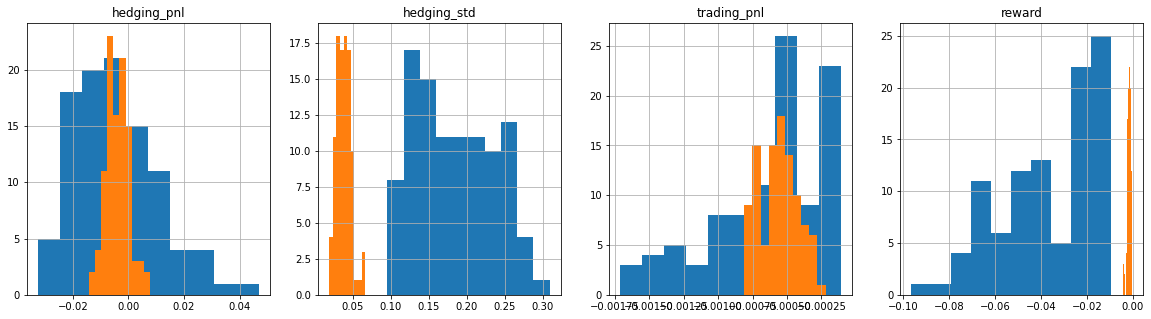

processing episode 400


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.002811,0.099852,-0.000699,-0.010885,-0.003877,0.038168,-0.000560,-0.001586
std,0.009147,0.028675,0.000271,0.006744,0.004115,0.009547,0.000142,0.000787
min,-0.023236,0.057351,-0.001330,-0.041837,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.002695,0.093627,-0.000725,-0.008803,-0.003721,0.037633,-0.000565,-0.001462
max,0.027558,0.202763,-0.000200,-0.003321,0.007877,0.066245,-0.000220,-0.000368


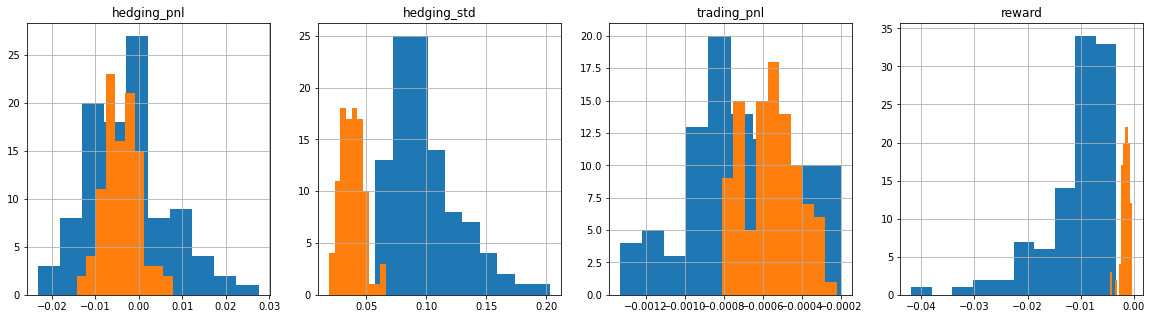

processing episode 500


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.004303,0.138646,-0.000586,-0.021305,-0.003877,0.038168,-0.000560,-0.001586
std,0.012749,0.043714,0.000332,0.013033,0.004115,0.009547,0.000142,0.000787
min,-0.036113,0.068131,-0.001440,-0.052038,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.001804,0.128864,-0.000510,-0.016921,-0.003721,0.037633,-0.000565,-0.001462
max,0.017818,0.228005,-0.000080,-0.004676,0.007877,0.066245,-0.000220,-0.000368


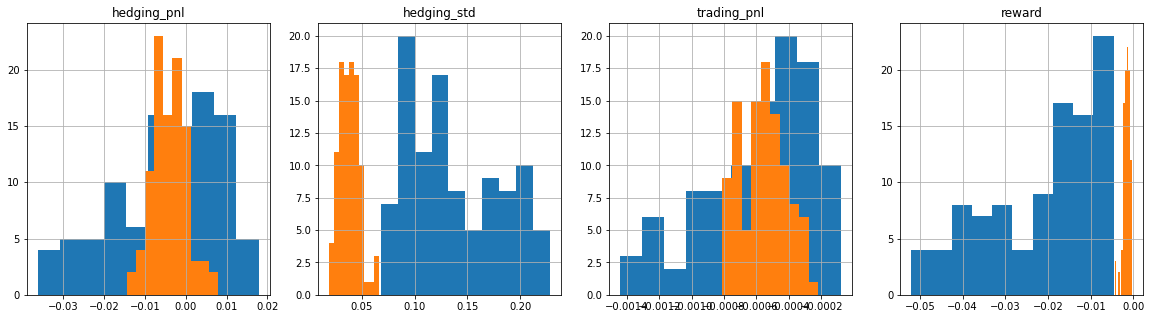

processing episode 600


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.004916,0.121543,-0.000784,-0.016116,-0.003877,0.038168,-0.000560,-0.001586
std,0.010849,0.034527,0.000321,0.008929,0.004115,0.009547,0.000142,0.000787
min,-0.027724,0.055167,-0.001850,-0.040454,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.005499,0.116962,-0.000715,-0.013773,-0.003721,0.037633,-0.000565,-0.001462
max,0.020737,0.200602,-0.000330,-0.003189,0.007877,0.066245,-0.000220,-0.000368


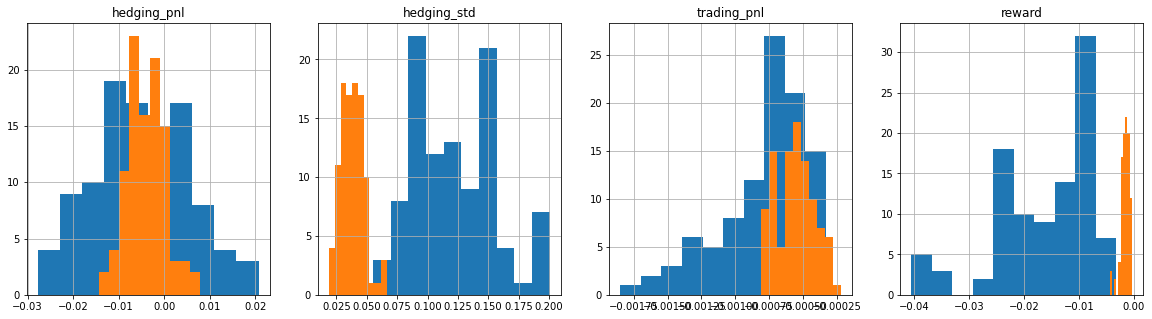

processing episode 700


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.002577,0.093710,-0.000660,-0.009241,-0.003877,0.038168,-0.000560,-0.001586
std,0.009165,0.019174,0.000259,0.003746,0.004115,0.009547,0.000142,0.000787
min,-0.020450,0.053956,-0.001400,-0.020450,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.004488,0.090171,-0.000660,-0.008216,-0.003721,0.037633,-0.000565,-0.001462
max,0.021816,0.143043,-0.000160,-0.003022,0.007877,0.066245,-0.000220,-0.000368


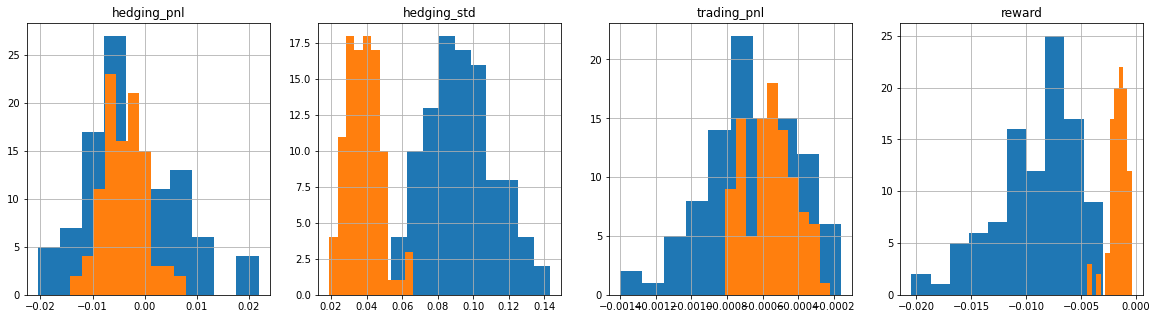

processing episode 800


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.003047,0.107425,-0.000564,-0.012342,-0.003877,0.038168,-0.000560,-0.001586
std,0.011887,0.025521,0.000243,0.005676,0.004115,0.009547,0.000142,0.000787
min,-0.027165,0.060363,-0.001210,-0.031489,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.003294,0.109666,-0.000585,-0.012109,-0.003721,0.037633,-0.000565,-0.001462
max,0.032955,0.174403,-0.000120,-0.003998,0.007877,0.066245,-0.000220,-0.000368


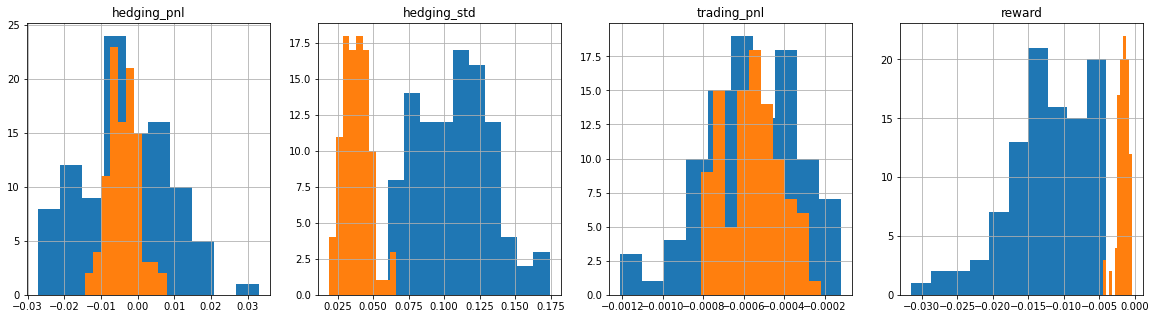

processing episode 900


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.003131,0.091912,-0.000546,-0.009015,-0.003877,0.038168,-0.000560,-0.001586
std,0.009598,0.021655,0.000230,0.004772,0.004115,0.009547,0.000142,0.000787
min,-0.024616,0.056704,-0.001420,-0.029738,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.003128,0.088718,-0.000525,-0.007904,-0.003721,0.037633,-0.000565,-0.001462
max,0.037997,0.172464,-0.000150,-0.003863,0.007877,0.066245,-0.000220,-0.000368


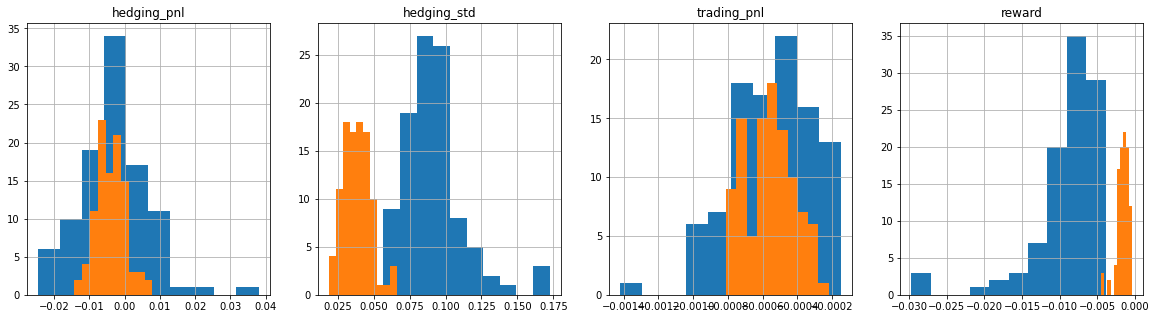

processing episode 1000


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.002495,0.115074,-0.000608,-0.014195,-0.003877,0.038168,-0.000560,-0.001586
std,0.010460,0.028913,0.000235,0.007261,0.004115,0.009547,0.000142,0.000787
min,-0.025504,0.071950,-0.001160,-0.042467,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.004757,0.111886,-0.000580,-0.012563,-0.003721,0.037633,-0.000565,-0.001462
max,0.030078,0.206034,-0.000170,-0.005319,0.007877,0.066245,-0.000220,-0.000368


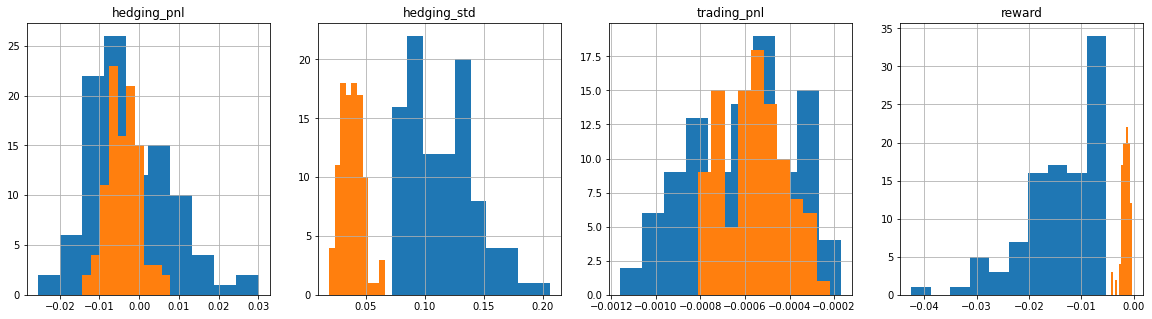

processing episode 1100


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.002199,0.188765,-0.000617,-0.039637,-0.003877,0.038168,-0.000560,-0.001586
std,0.020557,0.059871,0.000312,0.025405,0.004115,0.009547,0.000142,0.000787
min,-0.036703,0.096705,-0.001510,-0.124352,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.005260,0.176108,-0.000590,-0.031222,-0.003721,0.037633,-0.000565,-0.001462
max,0.057099,0.352499,-0.000170,-0.009925,0.007877,0.066245,-0.000220,-0.000368


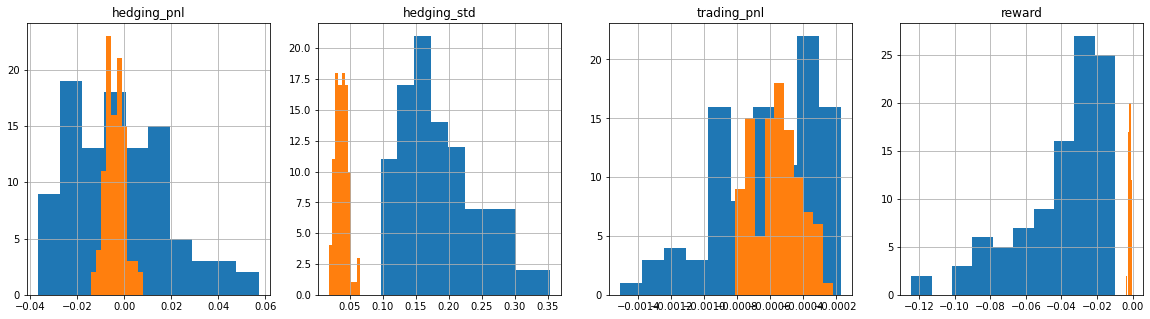

processing episode 1200


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.003673,0.093015,-0.000570,-0.009158,-0.003877,0.038168,-0.000560,-0.001586
std,0.009695,0.019805,0.000224,0.003746,0.004115,0.009547,0.000142,0.000787
min,-0.025690,0.043429,-0.001190,-0.020251,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.003587,0.091536,-0.000535,-0.008425,-0.003721,0.037633,-0.000565,-0.001462
max,0.020903,0.141735,-0.000140,-0.002338,0.007877,0.066245,-0.000220,-0.000368


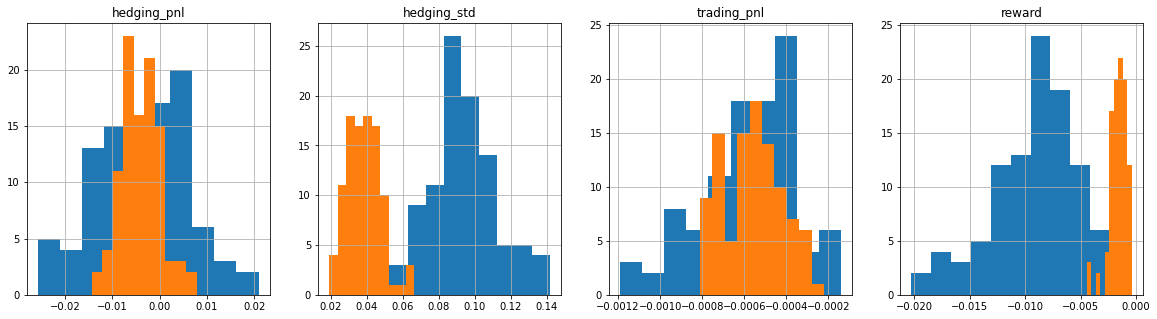

processing episode 1300


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.003132,0.094800,-0.000527,-0.009471,-0.003877,0.038168,-0.000560,-0.001586
std,0.009611,0.019461,0.000199,0.003759,0.004115,0.009547,0.000142,0.000787
min,-0.025369,0.044966,-0.001150,-0.020177,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.002259,0.095199,-0.000500,-0.009318,-0.003721,0.037633,-0.000565,-0.001462
max,0.019396,0.141299,-0.000180,-0.002040,0.007877,0.066245,-0.000220,-0.000368


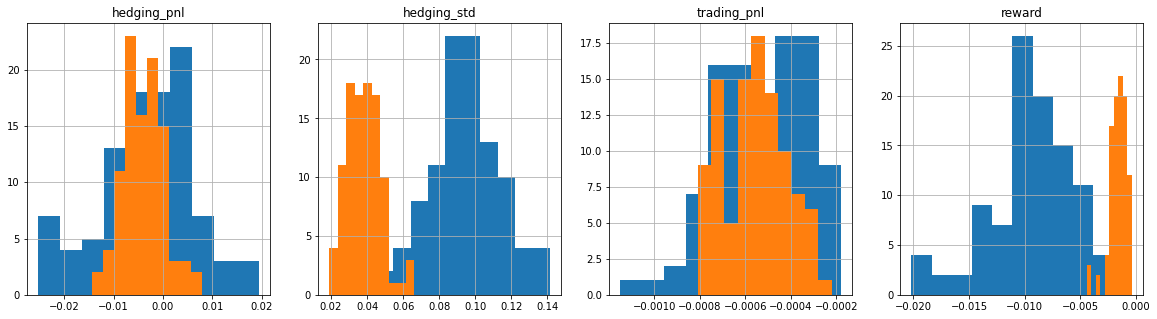

processing episode 1400


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.003858,0.094947,-0.000626,-0.009442,-0.003877,0.038168,-0.000560,-0.001586
std,0.010082,0.017350,0.000275,0.003432,0.004115,0.009547,0.000142,0.000787
min,-0.027470,0.059038,-0.001280,-0.022280,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.002492,0.092353,-0.000620,-0.008756,-0.003721,0.037633,-0.000565,-0.001462
max,0.015987,0.148924,-0.000160,-0.003500,0.007877,0.066245,-0.000220,-0.000368


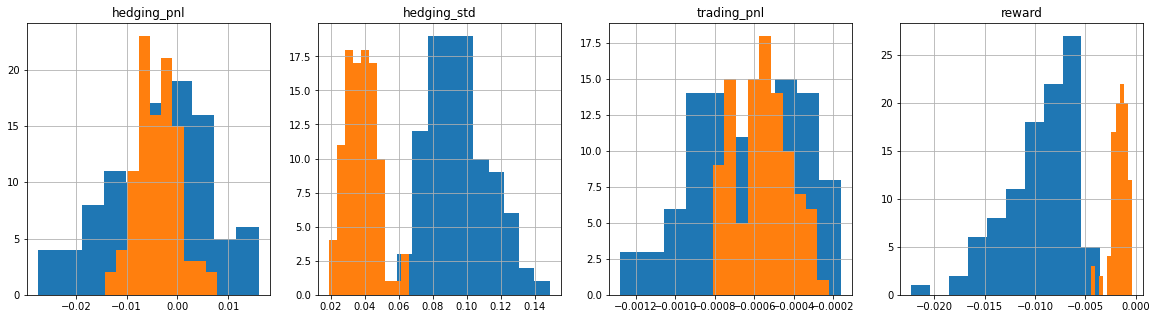

processing episode 1500


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.004424,0.103169,-0.000534,-0.011348,-0.003877,0.038168,-0.000560,-0.001586
std,0.010810,0.023716,0.000198,0.005046,0.004115,0.009547,0.000142,0.000787
min,-0.026087,0.051792,-0.001040,-0.030371,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.005065,0.101227,-0.000515,-0.010496,-0.003721,0.037633,-0.000565,-0.001462
max,0.029130,0.172002,-0.000200,-0.002827,0.007877,0.066245,-0.000220,-0.000368


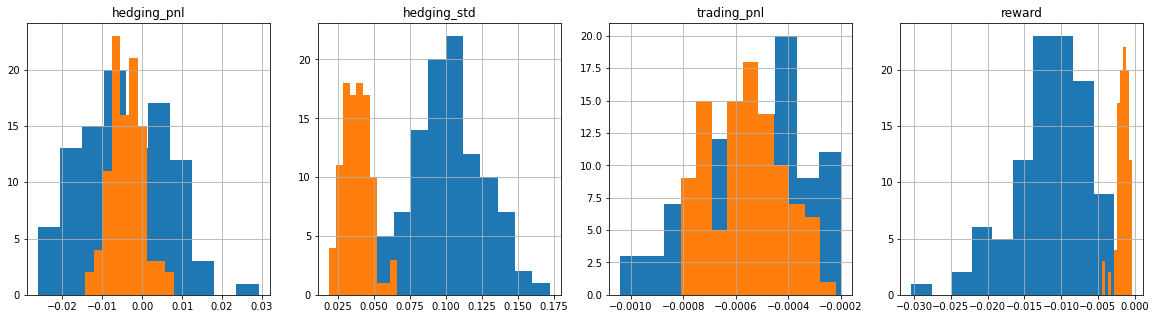

processing episode 1600


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.005395,0.115566,-0.000551,-0.014623,-0.003877,0.038168,-0.000560,-0.001586
std,0.012359,0.032954,0.000253,0.009544,0.004115,0.009547,0.000142,0.000787
min,-0.028268,0.068136,-0.001180,-0.058215,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.003292,0.110021,-0.000520,-0.012116,-0.003721,0.037633,-0.000565,-0.001462
max,0.023886,0.241267,-0.000120,-0.004751,0.007877,0.066245,-0.000220,-0.000368


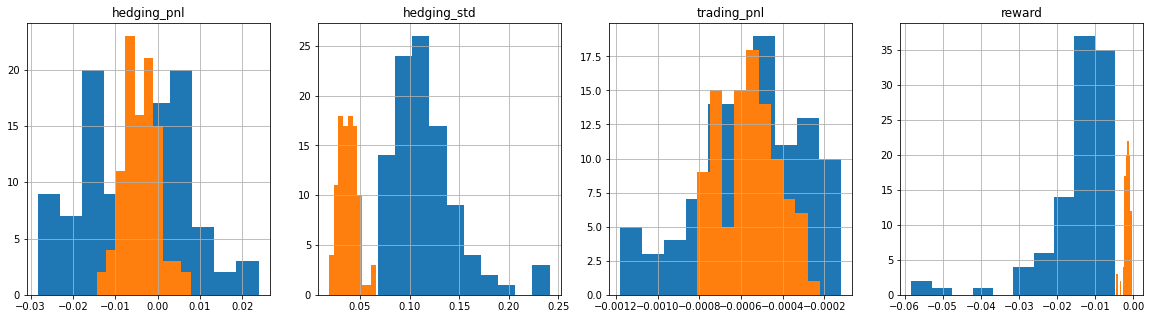

processing episode 1700


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.005309,0.193985,-0.000572,-0.040301,-0.003877,0.038168,-0.000560,-0.001586
std,0.022612,0.046237,0.000319,0.018154,0.004115,0.009547,0.000142,0.000787
min,-0.039198,0.097947,-0.001510,-0.103449,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.009566,0.196749,-0.000475,-0.039328,-0.003721,0.037633,-0.000565,-0.001462
max,0.056441,0.321058,-0.000090,-0.010254,0.007877,0.066245,-0.000220,-0.000368


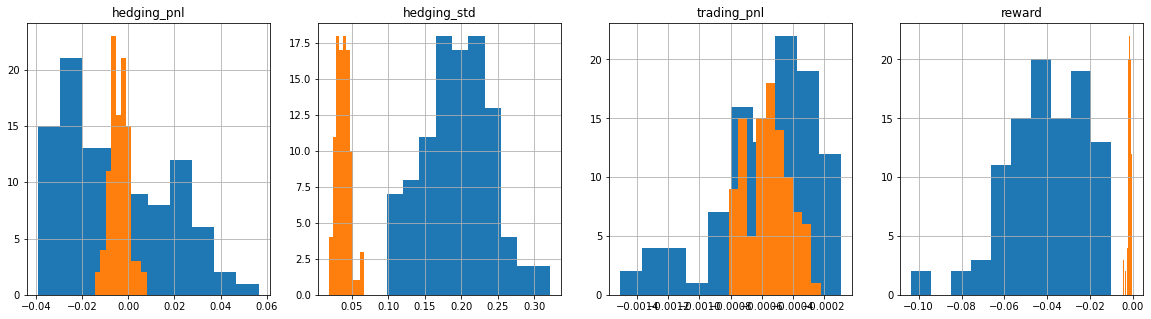

processing episode 1800


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.001708,0.177817,-0.000776,-0.036003,-0.003877,0.038168,-0.000560,-0.001586
std,0.018114,0.064030,0.000513,0.026453,0.004115,0.009547,0.000142,0.000787
min,-0.034223,0.072685,-0.002600,-0.128231,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.003182,0.162070,-0.000690,-0.026655,-0.003721,0.037633,-0.000565,-0.001462
max,0.075902,0.355997,-0.000090,-0.005284,0.007877,0.066245,-0.000220,-0.000368


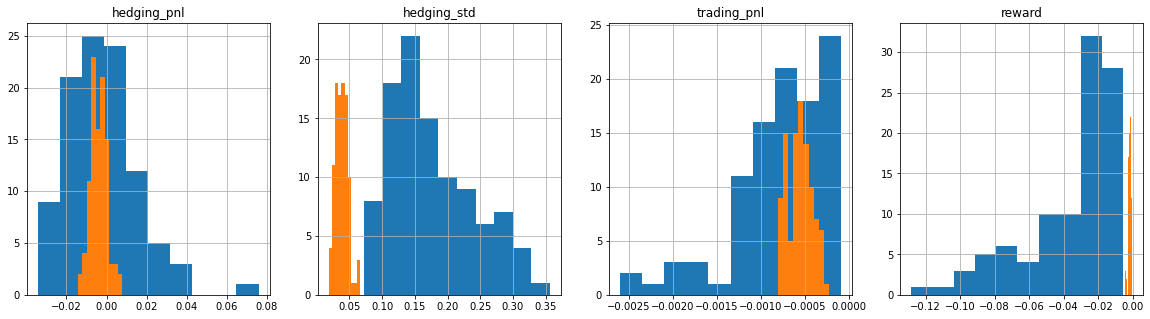

processing episode 1900


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.003622,0.139862,-0.000463,-0.020690,-0.003877,0.038168,-0.000560,-0.001586
std,0.014886,0.029995,0.000311,0.009039,0.004115,0.009547,0.000142,0.000787
min,-0.030364,0.076170,-0.001740,-0.052485,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.004526,0.136564,-0.000380,-0.018981,-0.003721,0.037633,-0.000565,-0.001462
max,0.048774,0.224875,-0.000090,-0.006508,0.007877,0.066245,-0.000220,-0.000368


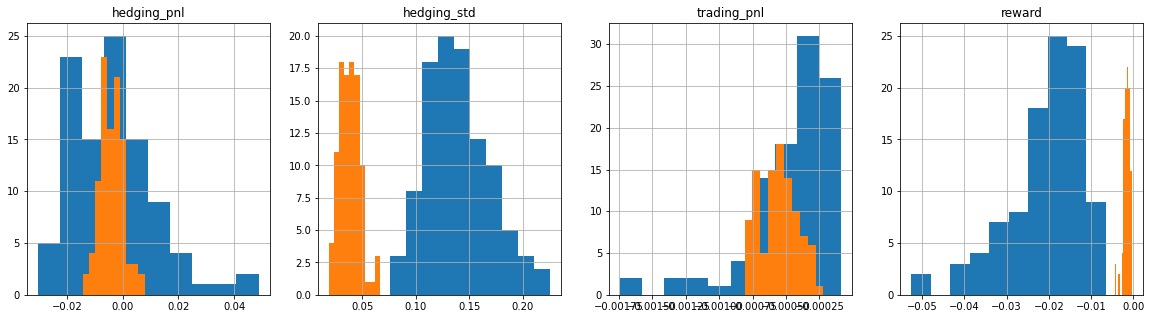

processing episode 2000


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.004235,0.128869,-0.000697,-0.017472,-0.003877,0.038168,-0.000560,-0.001586
std,0.013087,0.025884,0.000339,0.006685,0.004115,0.009547,0.000142,0.000787
min,-0.030976,0.064695,-0.001660,-0.036306,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.004106,0.134586,-0.000590,-0.018227,-0.003721,0.037633,-0.000565,-0.001462
max,0.039587,0.188707,-0.000190,-0.004551,0.007877,0.066245,-0.000220,-0.000368


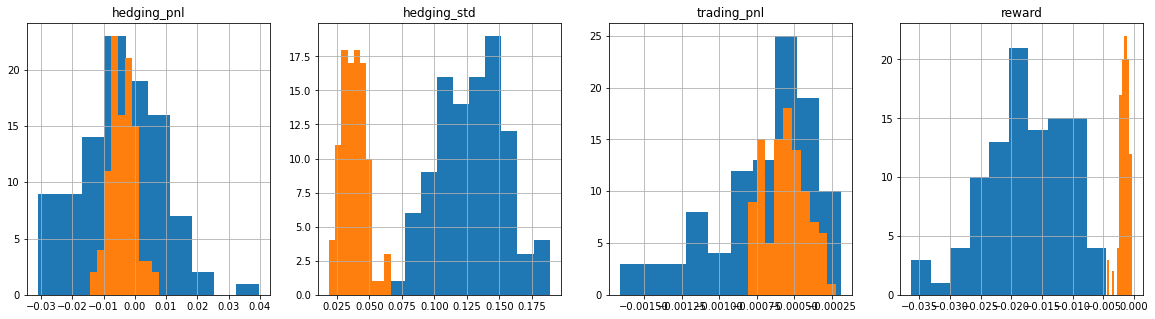

processing episode 2100


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.003601,0.129184,-0.000755,-0.017723,-0.003877,0.038168,-0.000560,-0.001586
std,0.012728,0.029287,0.000436,0.007701,0.004115,0.009547,0.000142,0.000787
min,-0.032923,0.065058,-0.002220,-0.042054,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.001417,0.131920,-0.000615,-0.017803,-0.003721,0.037633,-0.000565,-0.001462
max,0.022184,0.204731,-0.000090,-0.004644,0.007877,0.066245,-0.000220,-0.000368


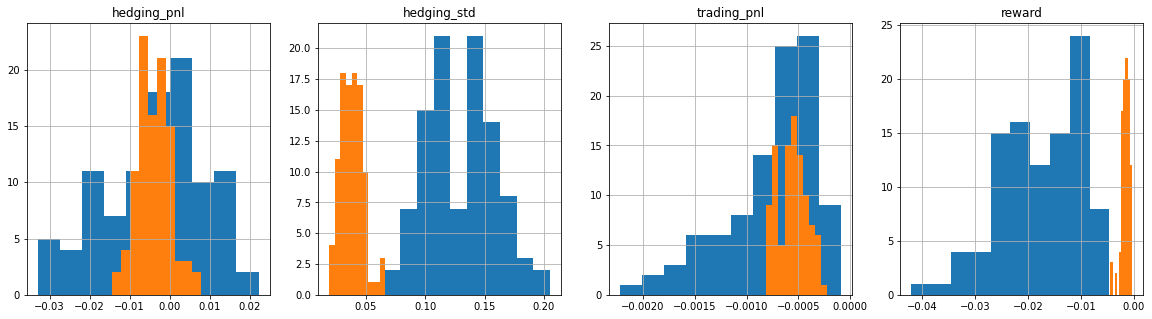

processing episode 2200


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.004760,0.139150,-0.000876,-0.024123,-0.003877,0.038168,-0.000560,-0.001586
std,0.016203,0.067232,0.001201,0.047690,0.004115,0.009547,0.000142,0.000787
min,-0.033080,0.071874,-0.011070,-0.479169,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.005947,0.130927,-0.000615,-0.017271,-0.003721,0.037633,-0.000565,-0.001462
max,0.066645,0.690267,-0.000110,-0.005743,0.007877,0.066245,-0.000220,-0.000368


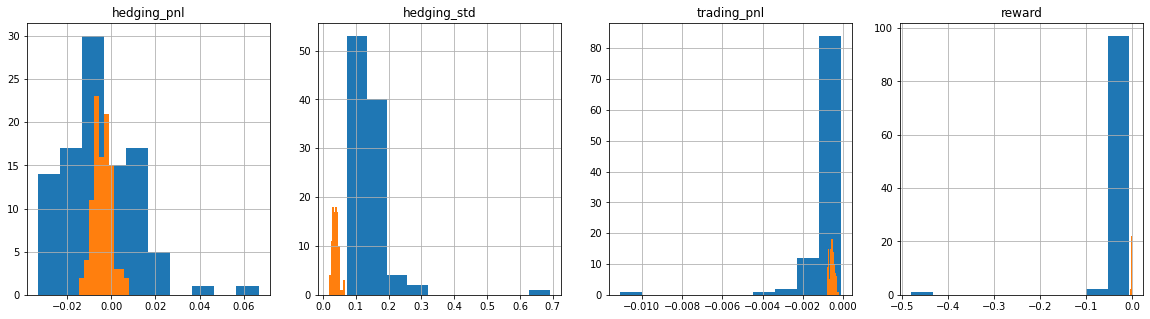

processing episode 2300


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.005650,0.157755,-0.000516,-0.026635,-0.003877,0.038168,-0.000560,-0.001586
std,0.018278,0.037217,0.000304,0.012209,0.004115,0.009547,0.000142,0.000787
min,-0.038932,0.088567,-0.001340,-0.065307,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.007221,0.161086,-0.000480,-0.026223,-0.003721,0.037633,-0.000565,-0.001462
max,0.028664,0.254506,-0.000080,-0.008841,0.007877,0.066245,-0.000220,-0.000368


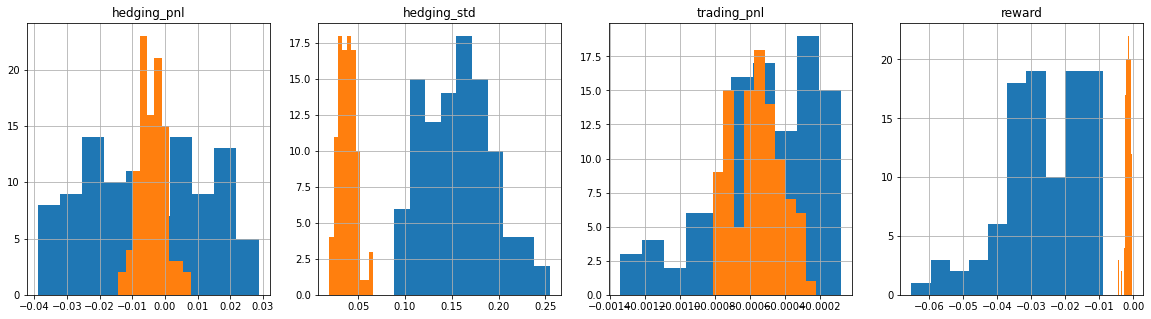

processing episode 2400


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.003634,0.115017,-0.000518,-0.013869,-0.003877,0.038168,-0.000560,-0.001586
std,0.012279,0.021765,0.000179,0.005247,0.004115,0.009547,0.000142,0.000787
min,-0.030808,0.067675,-0.001070,-0.033277,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.001912,0.114271,-0.000500,-0.013498,-0.003721,0.037633,-0.000565,-0.001462
max,0.020720,0.182143,-0.000080,-0.004586,0.007877,0.066245,-0.000220,-0.000368


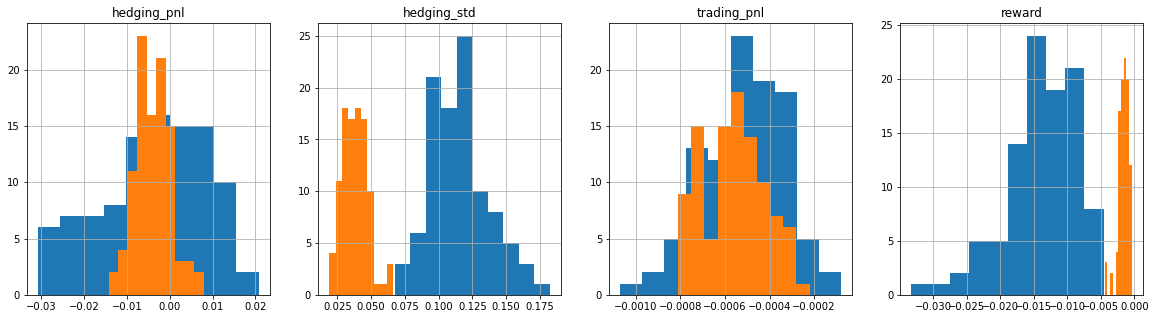

processing episode 2500


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.003826,0.129053,-0.000973,-0.019042,-0.003877,0.038168,-0.000560,-0.001586
std,0.013023,0.046810,0.000808,0.014865,0.004115,0.009547,0.000142,0.000787
min,-0.034960,0.061520,-0.005710,-0.089298,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.003693,0.121681,-0.000765,-0.014882,-0.003721,0.037633,-0.000565,-0.001462
max,0.032092,0.298854,-0.000270,-0.003818,0.007877,0.066245,-0.000220,-0.000368


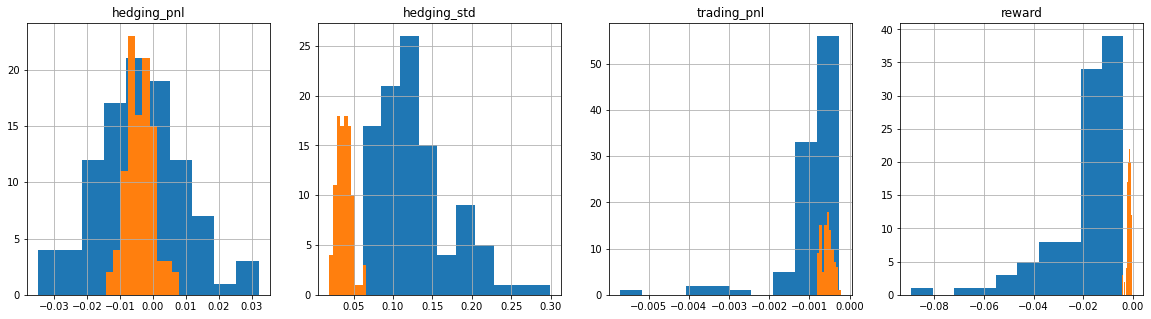

processing episode 2600


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.002748,0.165650,-0.000617,-0.030313,-0.003877,0.038168,-0.000560,-0.001586
std,0.016634,0.051030,0.000332,0.018795,0.004115,0.009547,0.000142,0.000787
min,-0.031609,0.075123,-0.002020,-0.094950,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.005081,0.160027,-0.000605,-0.025669,-0.003721,0.037633,-0.000565,-0.001462
max,0.045277,0.305196,-0.000090,-0.005782,0.007877,0.066245,-0.000220,-0.000368


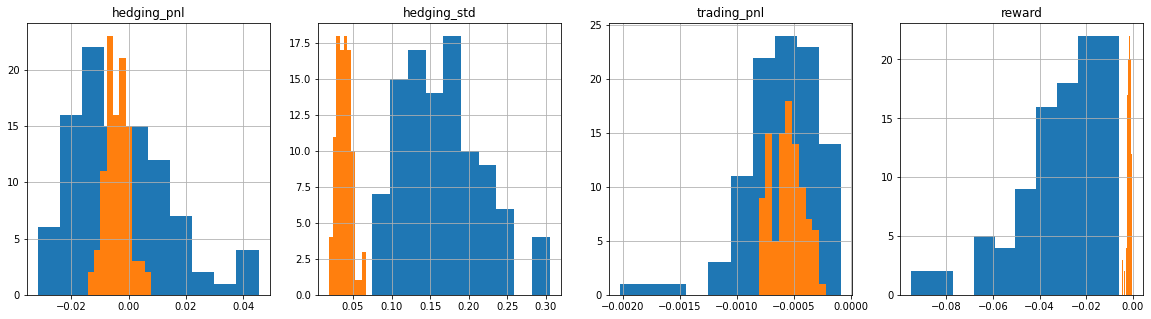

processing episode 2700


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.003564,0.131202,-0.000688,-0.020566,-0.003877,0.038168,-0.000560,-0.001586
std,0.014496,0.056152,0.000243,0.017234,0.004115,0.009547,0.000142,0.000787
min,-0.047672,0.052568,-0.001380,-0.076587,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.002227,0.113010,-0.000680,-0.012969,-0.003721,0.037633,-0.000565,-0.001462
max,0.030654,0.274940,-0.000180,-0.002926,0.007877,0.066245,-0.000220,-0.000368


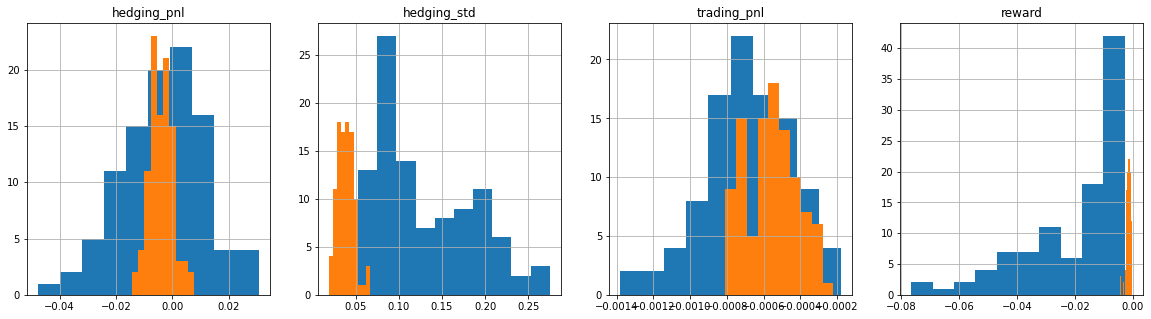

processing episode 2800


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.002886,0.180165,-0.000468,-0.037211,-0.003877,0.038168,-0.000560,-0.001586
std,0.017574,0.066937,0.000246,0.024998,0.004115,0.009547,0.000142,0.000787
min,-0.033188,0.063381,-0.001230,-0.101446,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.005140,0.178958,-0.000420,-0.032093,-0.003721,0.037633,-0.000565,-0.001462
max,0.042943,0.315906,-0.000050,-0.004394,0.007877,0.066245,-0.000220,-0.000368


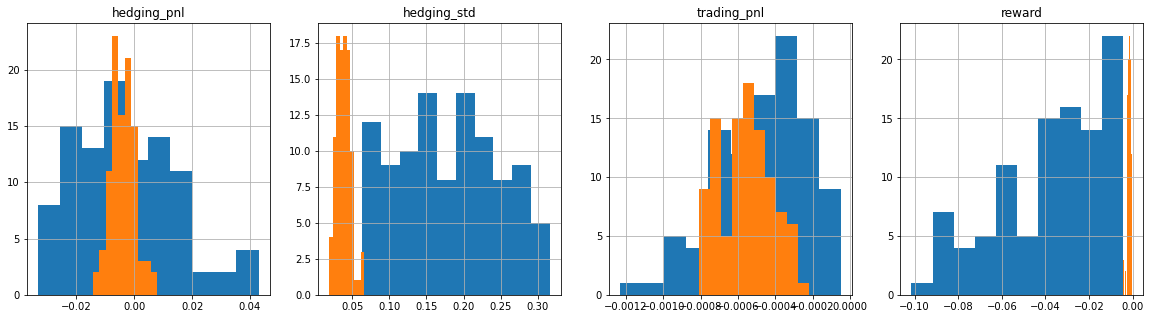

processing episode 2900


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.001342,0.121219,-0.000685,-0.015443,-0.003877,0.038168,-0.000560,-0.001586
std,0.014247,0.023403,0.000311,0.006094,0.004115,0.009547,0.000142,0.000787
min,-0.030654,0.071741,-0.001460,-0.034914,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.003463,0.116969,-0.000615,-0.013760,-0.003721,0.037633,-0.000565,-0.001462
max,0.044450,0.185273,-0.000200,-0.005487,0.007877,0.066245,-0.000220,-0.000368


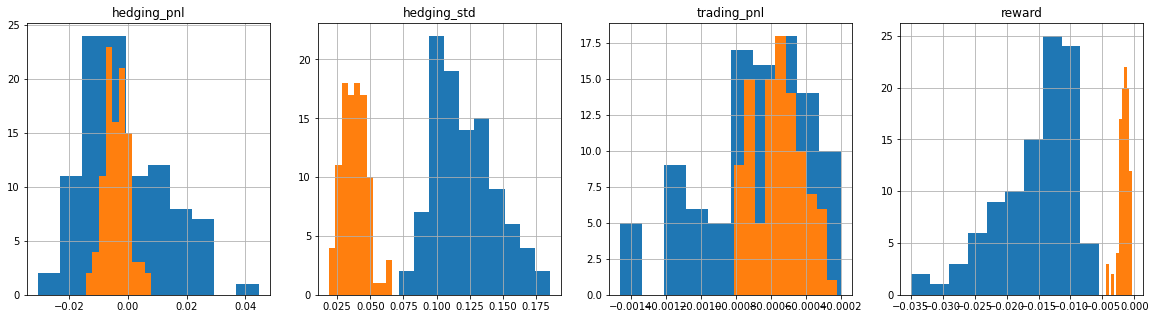

processing episode 3000


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.000258,0.437491,-0.001039,-0.222195,-0.003877,0.038168,-0.000560,-0.001586
std,0.042040,0.171260,0.000400,0.164563,0.004115,0.009547,0.000142,0.000787
min,-0.117843,0.118073,-0.001910,-0.682198,-0.014317,0.018925,-0.000810,-0.004438
50%,0.010287,0.410026,-0.001045,-0.171588,-0.003721,0.037633,-0.000565,-0.001462
max,0.091330,0.820850,-0.000240,-0.014046,0.007877,0.066245,-0.000220,-0.000368


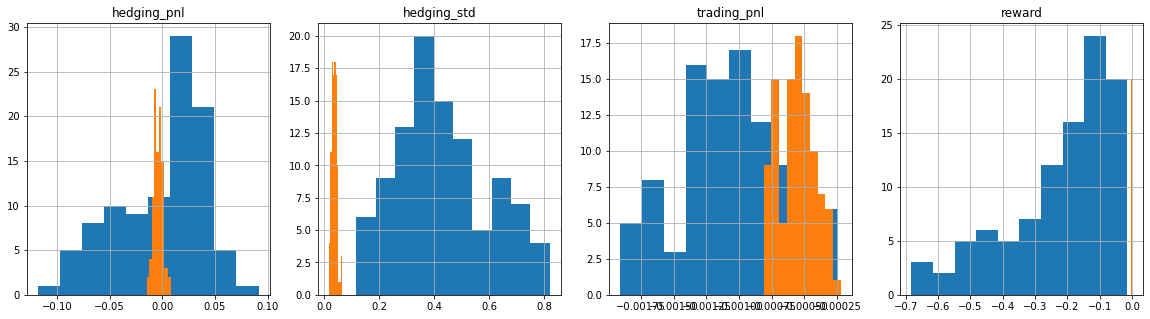

processing episode 3100


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.001665,0.476138,-0.000800,-0.253435,-0.003877,0.038168,-0.000560,-0.001586
std,0.049658,0.156569,0.000458,0.157002,0.004115,0.009547,0.000142,0.000787
min,-0.064158,0.206826,-0.002540,-0.671649,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.015923,0.477789,-0.000630,-0.231654,-0.003721,0.037633,-0.000565,-0.001462
max,0.121628,0.814151,-0.000210,-0.045549,0.007877,0.066245,-0.000220,-0.000368


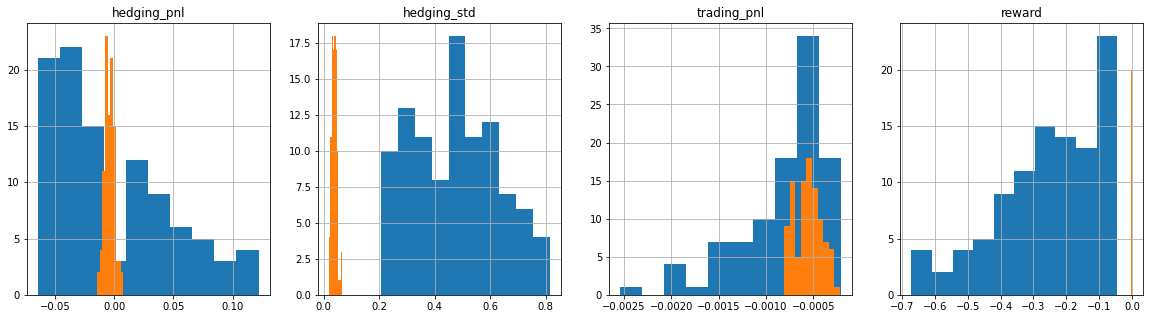

processing episode 3200


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.004469,0.151878,-0.000946,-0.026197,-0.003877,0.038168,-0.000560,-0.001586
std,0.016967,0.053171,0.000682,0.020991,0.004115,0.009547,0.000142,0.000787
min,-0.048424,0.069652,-0.003240,-0.142606,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.005131,0.143640,-0.000660,-0.020829,-0.003721,0.037633,-0.000565,-0.001462
max,0.038888,0.375931,-0.000240,-0.004862,0.007877,0.066245,-0.000220,-0.000368


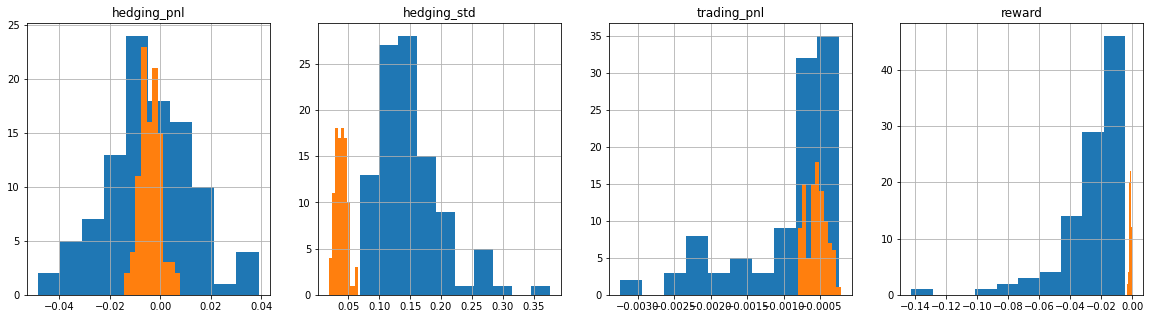

processing episode 3300


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.004072,0.222352,-0.000188,-0.055117,-0.003877,0.038168,-0.000560,-0.001586
std,0.023902,0.071688,0.000076,0.032370,0.004115,0.009547,0.000142,0.000787
min,-0.033784,0.077857,-0.000370,-0.151408,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.010747,0.228948,-0.000180,-0.052596,-0.003721,0.037633,-0.000565,-0.001462
max,0.061266,0.388207,-0.000040,-0.007038,0.007877,0.066245,-0.000220,-0.000368


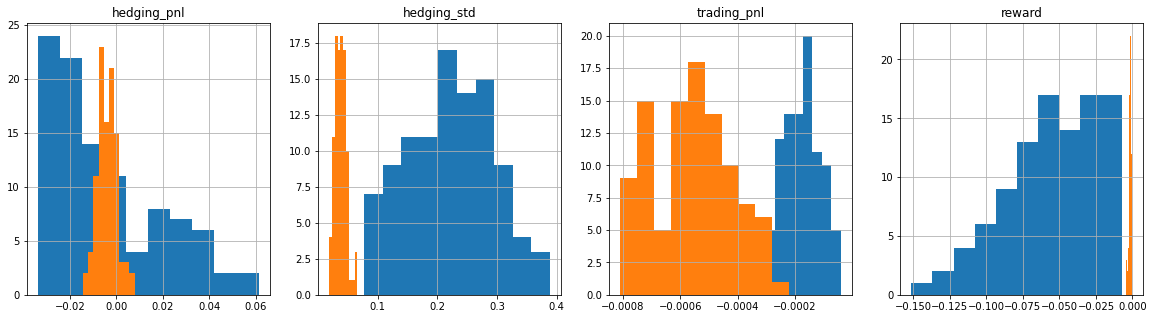

processing episode 3400


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.003319,0.121911,-0.000501,-0.015353,-0.003877,0.038168,-0.000560,-0.001586
std,0.011563,0.018551,0.000269,0.004757,0.004115,0.009547,0.000142,0.000787
min,-0.024185,0.072442,-0.001290,-0.031927,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.004231,0.122866,-0.000460,-0.015196,-0.003721,0.037633,-0.000565,-0.001462
max,0.028994,0.178644,-0.000070,-0.005514,0.007877,0.066245,-0.000220,-0.000368


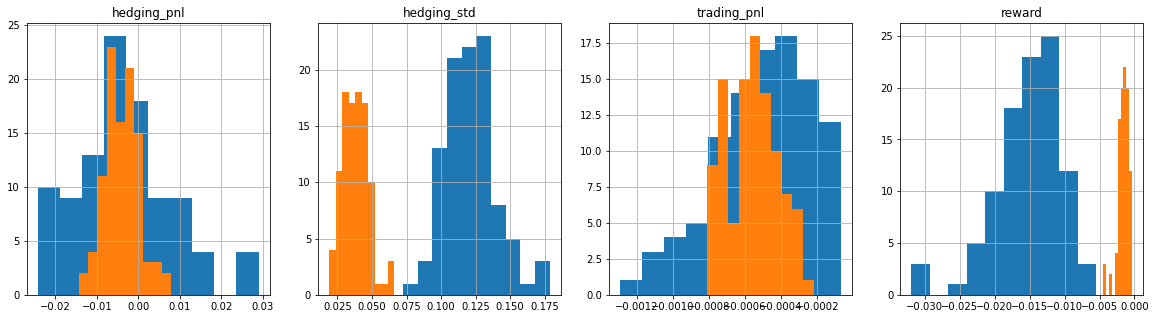

processing episode 3500


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.001298,0.169137,-0.000765,-0.031955,-0.003877,0.038168,-0.000560,-0.001586
std,0.020534,0.054414,0.000363,0.019144,0.004115,0.009547,0.000142,0.000787
min,-0.034354,0.059580,-0.002010,-0.082102,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.004677,0.171048,-0.000710,-0.029728,-0.003721,0.037633,-0.000565,-0.001462
max,0.056682,0.282679,-0.000150,-0.003808,0.007877,0.066245,-0.000220,-0.000368


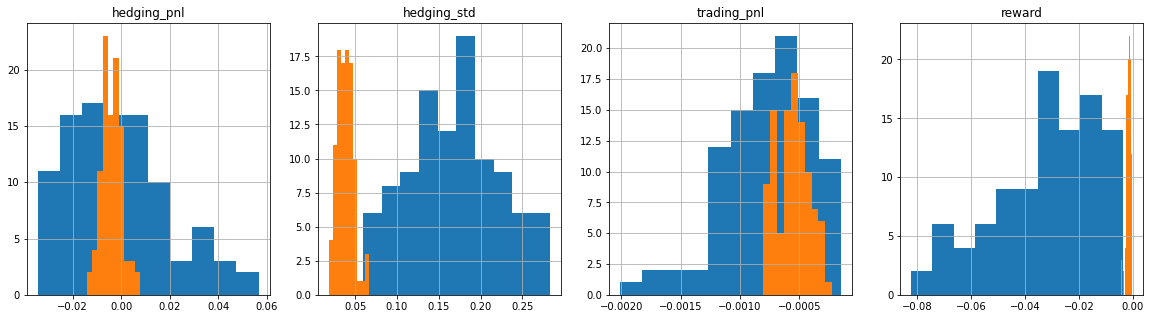

processing episode 3600


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.003964,0.143724,-0.000639,-0.021528,-0.003877,0.038168,-0.000560,-0.001586
std,0.013456,0.025907,0.000296,0.007504,0.004115,0.009547,0.000142,0.000787
min,-0.032864,0.083156,-0.001430,-0.040011,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.005332,0.145027,-0.000595,-0.021154,-0.003721,0.037633,-0.000565,-0.001462
max,0.034522,0.199444,-0.000150,-0.007170,0.007877,0.066245,-0.000220,-0.000368


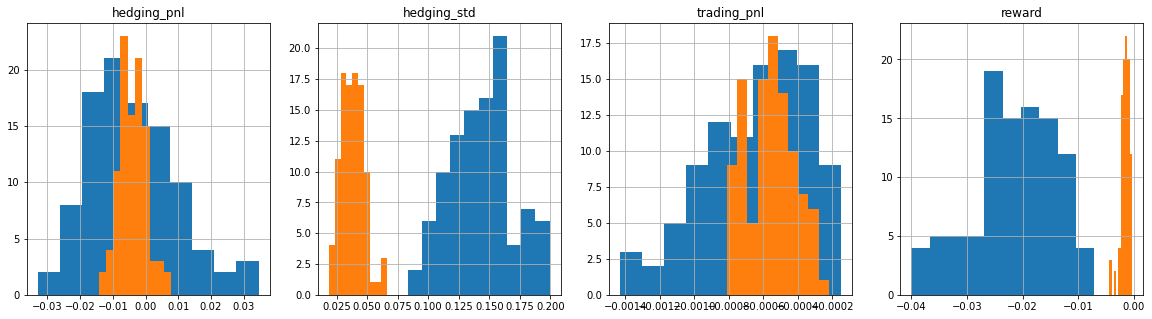

processing episode 3700


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.003235,0.211762,-0.000790,-0.049868,-0.003877,0.038168,-0.000560,-0.001586
std,0.025239,0.066701,0.000446,0.030477,0.004115,0.009547,0.000142,0.000787
min,-0.045152,0.108085,-0.002130,-0.123959,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.007702,0.204396,-0.000705,-0.042661,-0.003721,0.037633,-0.000565,-0.001462
max,0.069011,0.346332,-0.000150,-0.012397,0.007877,0.066245,-0.000220,-0.000368


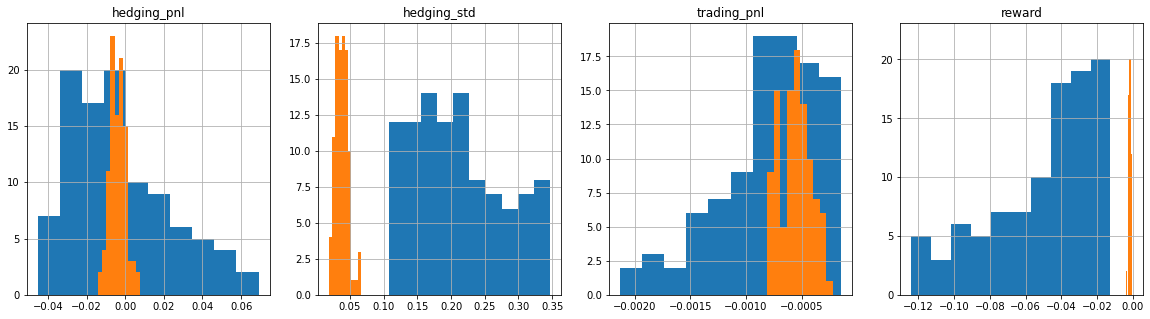

processing episode 3800


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.001211,0.213140,-0.000874,-0.051935,-0.003877,0.038168,-0.000560,-0.001586
std,0.027171,0.076378,0.000502,0.033968,0.004115,0.009547,0.000142,0.000787
min,-0.043739,0.078638,-0.002220,-0.126970,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.003546,0.210306,-0.000770,-0.045704,-0.003721,0.037633,-0.000565,-0.001462
max,0.066094,0.351806,-0.000160,-0.006374,0.007877,0.066245,-0.000220,-0.000368


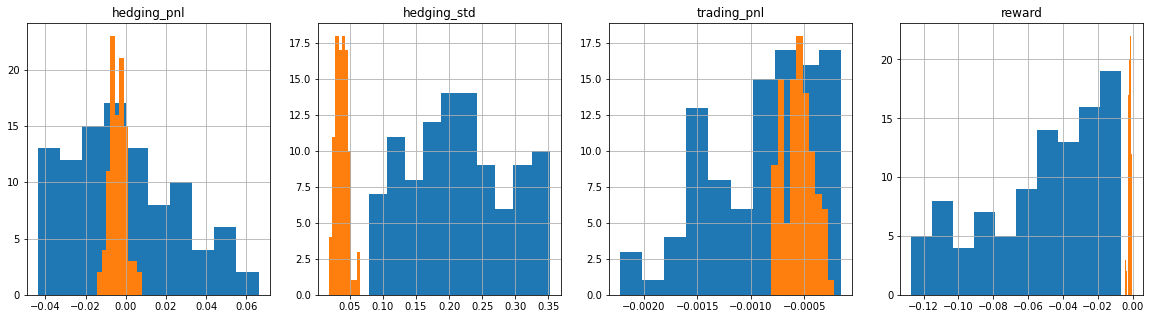

processing episode 3900


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.002890,0.127969,-0.000679,-0.017876,-0.003877,0.038168,-0.000560,-0.001586
std,0.013260,0.036350,0.000322,0.010281,0.004115,0.009547,0.000142,0.000787
min,-0.029851,0.061776,-0.001390,-0.054693,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.003228,0.123731,-0.000665,-0.015356,-0.003721,0.037633,-0.000565,-0.001462
max,0.033897,0.232404,-0.000090,-0.004017,0.007877,0.066245,-0.000220,-0.000368


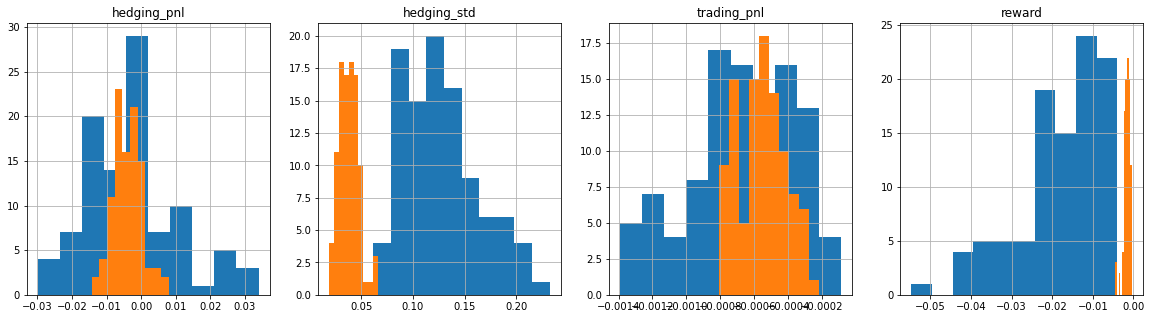

processing episode 4000


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.004021,0.086874,-0.000610,-0.007891,-0.003877,0.038168,-0.000560,-0.001586
std,0.009060,0.015419,0.000242,0.002870,0.004115,0.009547,0.000142,0.000787
min,-0.026184,0.058925,-0.001250,-0.018853,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.004713,0.085555,-0.000575,-0.007469,-0.003721,0.037633,-0.000565,-0.001462
max,0.016320,0.137020,-0.000110,-0.003522,0.007877,0.066245,-0.000220,-0.000368


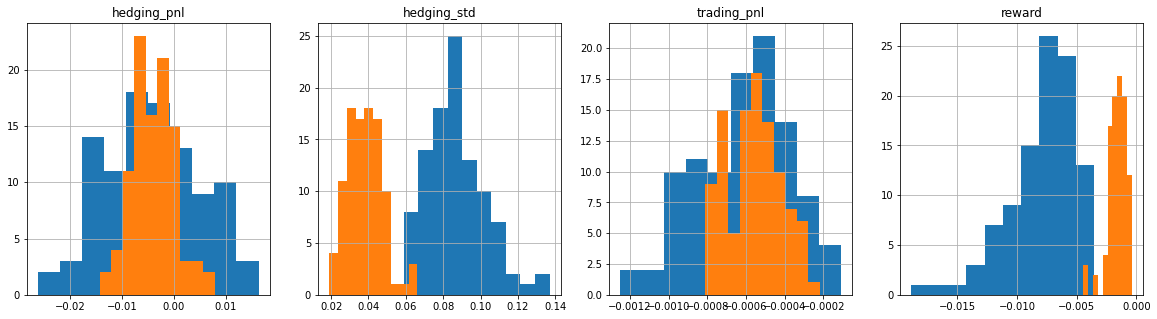

processing episode 4100


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.004853,0.165981,-0.000470,-0.029432,-0.003877,0.038168,-0.000560,-0.001586
std,0.019605,0.038602,0.000295,0.012674,0.004115,0.009547,0.000142,0.000787
min,-0.035690,0.075766,-0.001270,-0.062332,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.007958,0.165410,-0.000380,-0.027453,-0.003721,0.037633,-0.000565,-0.001462
max,0.045099,0.248873,-0.000050,-0.006652,0.007877,0.066245,-0.000220,-0.000368


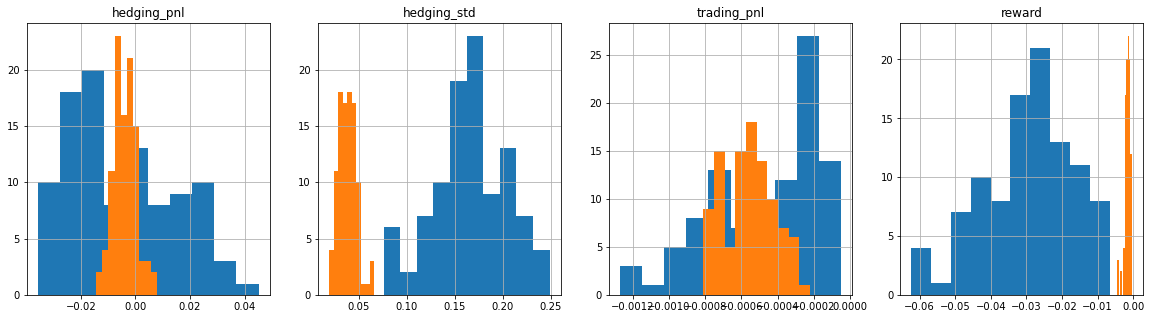

processing episode 4200


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.004633,0.135676,-0.000712,-0.019458,-0.003877,0.038168,-0.000560,-0.001586
std,0.013834,0.028874,0.000360,0.008124,0.004115,0.009547,0.000142,0.000787
min,-0.028893,0.069322,-0.001460,-0.042552,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.007962,0.132773,-0.000625,-0.017697,-0.003721,0.037633,-0.000565,-0.001462
max,0.031560,0.206050,-0.000150,-0.004961,0.007877,0.066245,-0.000220,-0.000368


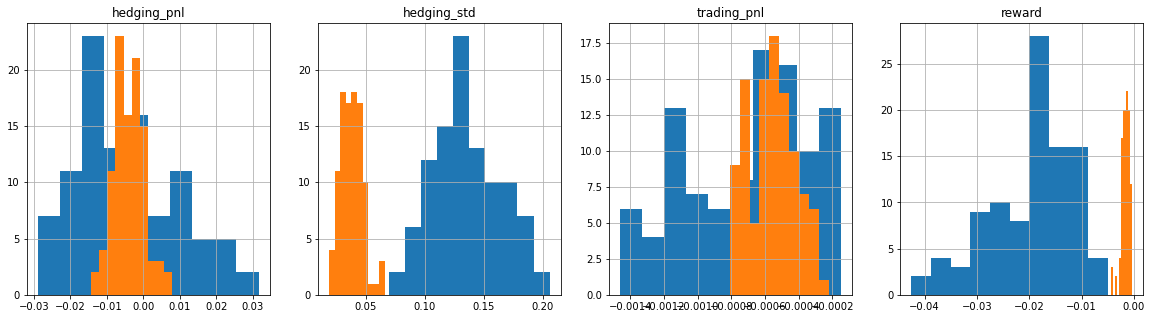

processing episode 4300


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.002102,0.152567,-0.000478,-0.024683,-0.003877,0.038168,-0.000560,-0.001586
std,0.015621,0.034122,0.000306,0.011459,0.004115,0.009547,0.000142,0.000787
min,-0.028525,0.095460,-0.001770,-0.062110,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.004506,0.146858,-0.000400,-0.022129,-0.003721,0.037633,-0.000565,-0.001462
max,0.045823,0.245689,-0.000070,-0.009466,0.007877,0.066245,-0.000220,-0.000368


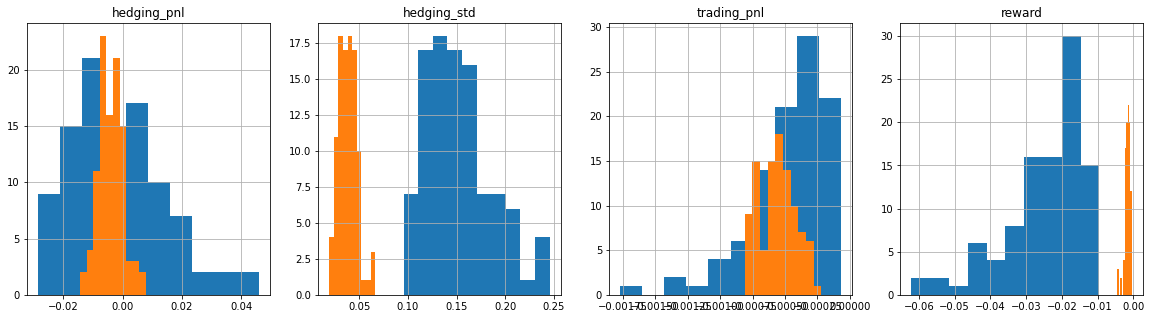

processing episode 4400


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.001119,0.124302,-0.000671,-0.016248,-0.003877,0.038168,-0.000560,-0.001586
std,0.013199,0.024914,0.000306,0.006290,0.004115,0.009547,0.000142,0.000787
min,-0.028057,0.070278,-0.001600,-0.030992,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.002649,0.122509,-0.000670,-0.015204,-0.003721,0.037633,-0.000565,-0.001462
max,0.033609,0.175748,-0.000150,-0.005112,0.007877,0.066245,-0.000220,-0.000368


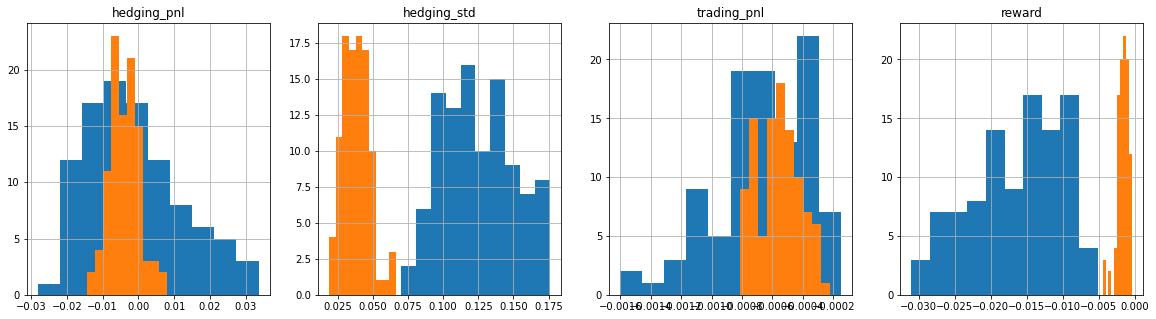

processing episode 4500


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.005124,0.119817,-0.000698,-0.015169,-0.003877,0.038168,-0.000560,-0.001586
std,0.013103,0.024549,0.000329,0.006348,0.004115,0.009547,0.000142,0.000787
min,-0.038664,0.067434,-0.001760,-0.044514,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.005414,0.117704,-0.000670,-0.014235,-0.003721,0.037633,-0.000565,-0.001462
max,0.028076,0.209574,-0.000120,-0.004593,0.007877,0.066245,-0.000220,-0.000368


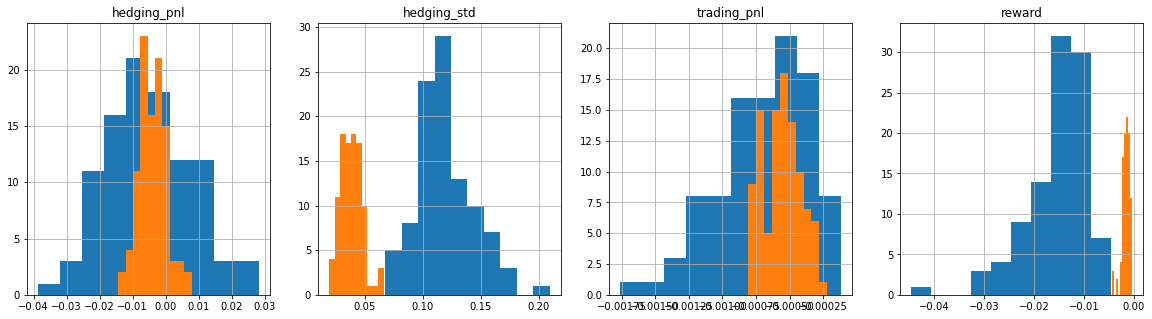

processing episode 4600


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.004711,0.179906,-0.000427,-0.034451,-0.003877,0.038168,-0.000560,-0.001586
std,0.020639,0.040650,0.000310,0.016165,0.004115,0.009547,0.000142,0.000787
min,-0.036685,0.089525,-0.001270,-0.104778,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.010352,0.175922,-0.000350,-0.031573,-0.003721,0.037633,-0.000565,-0.001462
max,0.039460,0.323216,-0.000030,-0.009004,0.007877,0.066245,-0.000220,-0.000368


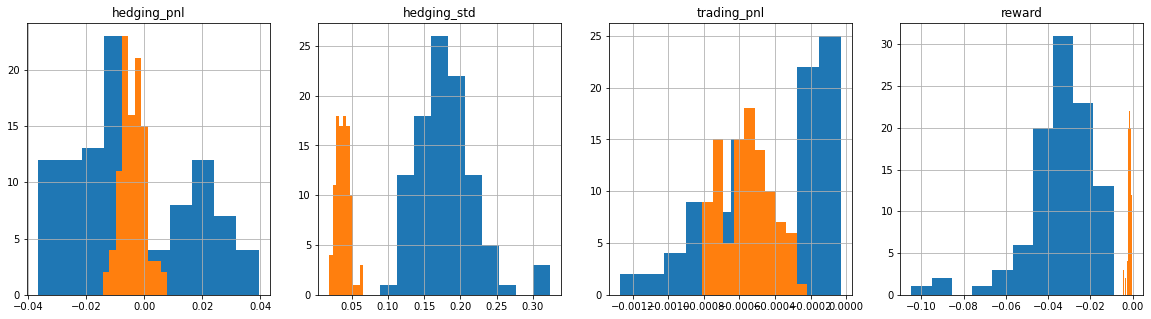

processing episode 4700


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.004451,0.210044,-0.000330,-0.053996,-0.003877,0.038168,-0.000560,-0.001586
std,0.020254,0.097669,0.000349,0.050607,0.004115,0.009547,0.000142,0.000787
min,-0.035571,0.084702,-0.001510,-0.252161,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.004015,0.169187,-0.000200,-0.028916,-0.003721,0.037633,-0.000565,-0.001462
max,0.071918,0.499898,-0.000010,-0.007254,0.007877,0.066245,-0.000220,-0.000368


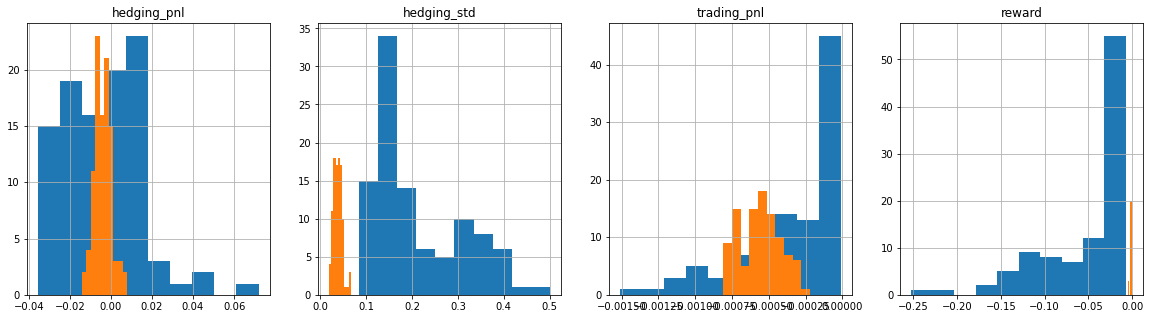

processing episode 4800


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.006468,0.186961,-0.000573,-0.036804,-0.003877,0.038168,-0.000560,-0.001586
std,0.020408,0.037293,0.000266,0.014095,0.004115,0.009547,0.000142,0.000787
min,-0.042539,0.097877,-0.001260,-0.074505,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.006947,0.183787,-0.000530,-0.034357,-0.003721,0.037633,-0.000565,-0.001462
max,0.040492,0.272506,-0.000120,-0.011030,0.007877,0.066245,-0.000220,-0.000368


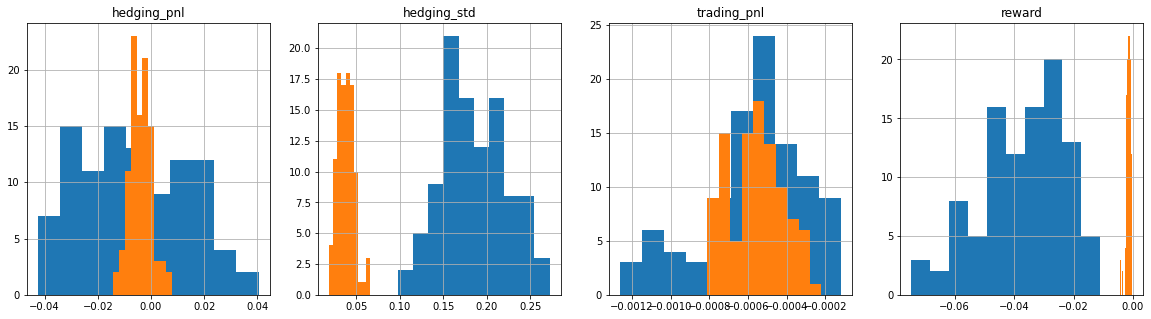

processing episode 4900


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.003509,0.142463,-0.000455,-0.021401,-0.003877,0.038168,-0.000560,-0.001586
std,0.014252,0.029894,0.000249,0.008402,0.004115,0.009547,0.000142,0.000787
min,-0.030856,0.066559,-0.001690,-0.041205,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.004560,0.143047,-0.000430,-0.020604,-0.003721,0.037633,-0.000565,-0.001462
max,0.032288,0.202346,-0.000080,-0.005072,0.007877,0.066245,-0.000220,-0.000368


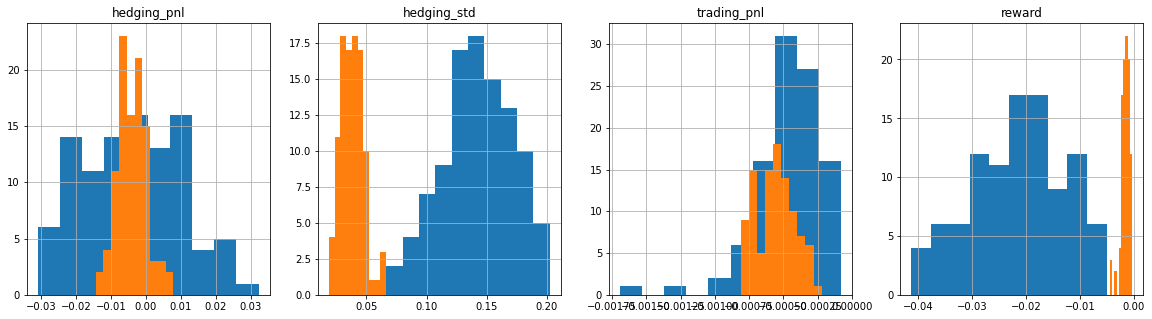

processing episode 5000


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.005221,0.277135,-0.001123,-0.080850,-0.003877,0.038168,-0.000560,-0.001586
std,0.029119,0.056371,0.000851,0.031596,0.004115,0.009547,0.000142,0.000787
min,-0.046911,0.175623,-0.003950,-0.152670,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.003678,0.277610,-0.000785,-0.077892,-0.003721,0.037633,-0.000565,-0.001462
max,0.083829,0.390275,-0.000200,-0.033089,0.007877,0.066245,-0.000220,-0.000368


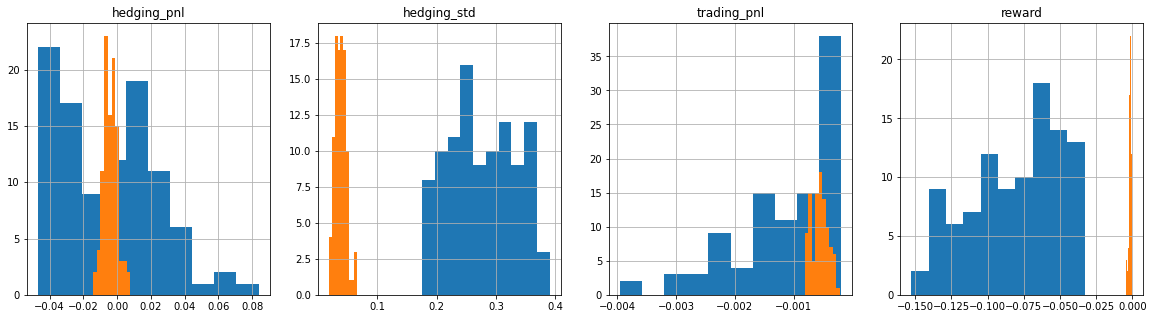

processing episode 5100


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.003285,0.219018,-0.000903,-0.052123,-0.003877,0.038168,-0.000560,-0.001586
std,0.025676,0.059287,0.000531,0.025672,0.004115,0.009547,0.000142,0.000787
min,-0.049425,0.094946,-0.003110,-0.113029,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.001175,0.226754,-0.000790,-0.052525,-0.003721,0.037633,-0.000565,-0.001462
max,0.096494,0.334927,-0.000200,-0.009041,0.007877,0.066245,-0.000220,-0.000368


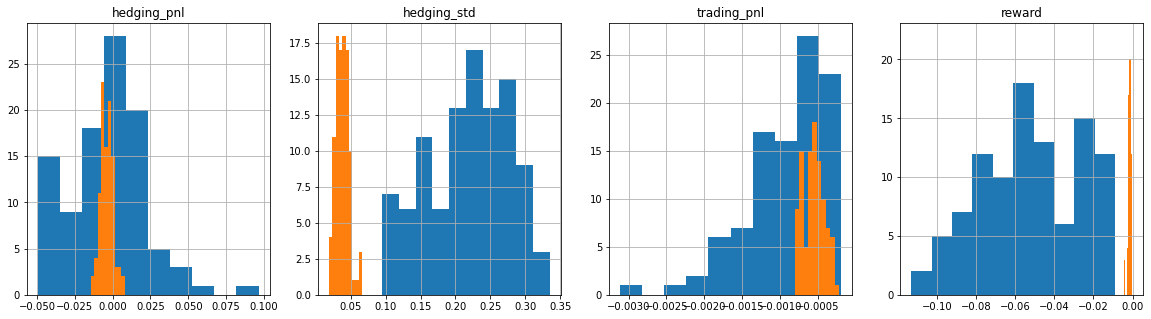

processing episode 5200


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.003384,0.117187,-0.000738,-0.015506,-0.003877,0.038168,-0.000560,-0.001586
std,0.012583,0.040187,0.000267,0.010735,0.004115,0.009547,0.000142,0.000787
min,-0.033821,0.060445,-0.001520,-0.046647,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.002033,0.106234,-0.000715,-0.011413,-0.003721,0.037633,-0.000565,-0.001462
max,0.033371,0.215257,-0.000190,-0.003677,0.007877,0.066245,-0.000220,-0.000368


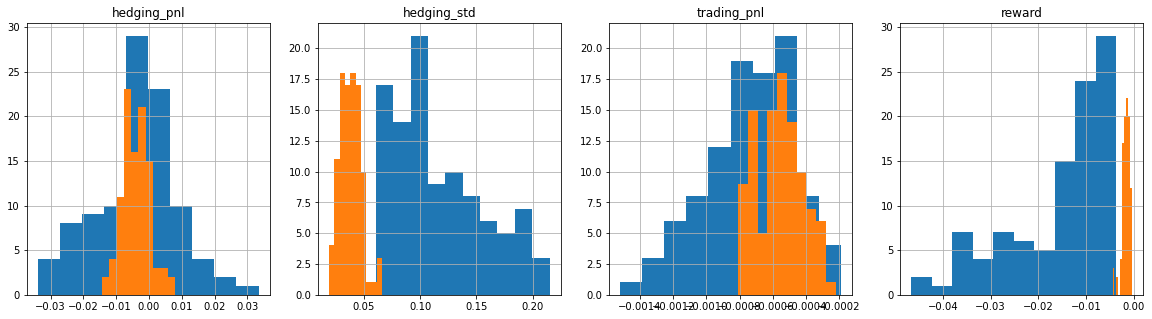

processing episode 5300


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.002257,0.108038,-0.000716,-0.012684,-0.003877,0.038168,-0.000560,-0.001586
std,0.011623,0.029496,0.000271,0.007313,0.004115,0.009547,0.000142,0.000787
min,-0.023876,0.065541,-0.001770,-0.037986,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.001373,0.099614,-0.000700,-0.010050,-0.003721,0.037633,-0.000565,-0.001462
max,0.033222,0.194186,-0.000210,-0.004304,0.007877,0.066245,-0.000220,-0.000368


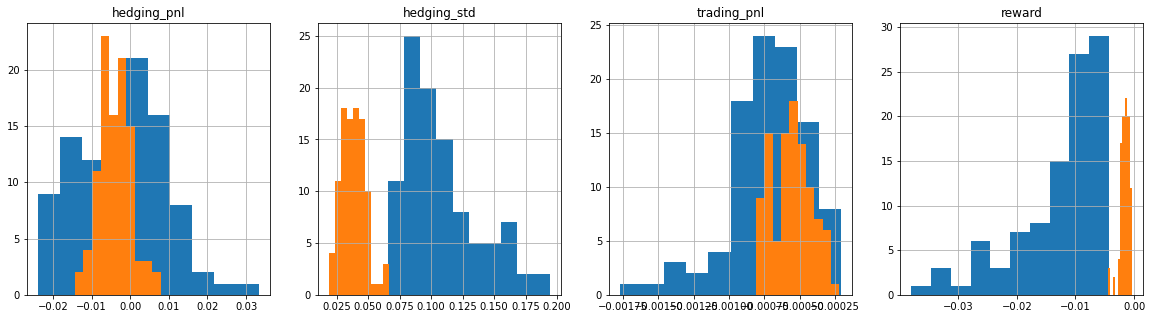

processing episode 5400


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.005068,0.192054,-0.000564,-0.038631,-0.003877,0.038168,-0.000560,-0.001586
std,0.022684,0.034813,0.000250,0.013517,0.004115,0.009547,0.000142,0.000787
min,-0.039750,0.096940,-0.001120,-0.085712,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.005833,0.187250,-0.000530,-0.035667,-0.003721,0.037633,-0.000565,-0.001462
max,0.046176,0.292618,-0.000080,-0.010818,0.007877,0.066245,-0.000220,-0.000368


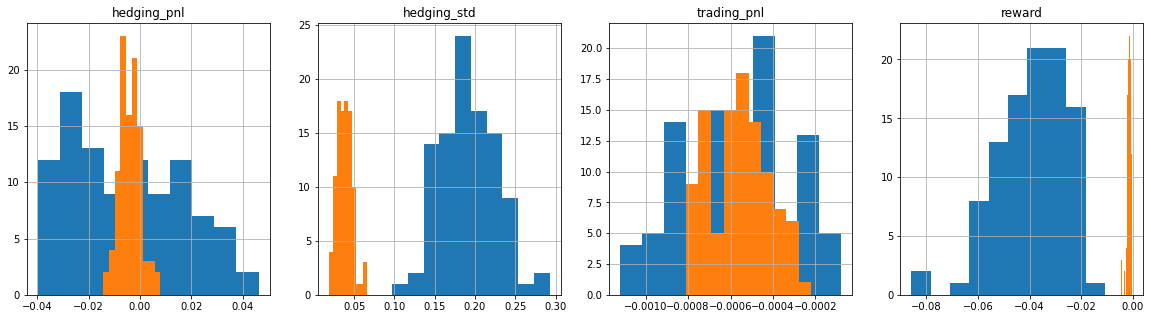

processing episode 5500


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.003069,0.162677,-0.000806,-0.027633,-0.003877,0.038168,-0.000560,-0.001586
std,0.018850,0.028416,0.000519,0.009515,0.004115,0.009547,0.000142,0.000787
min,-0.040436,0.101528,-0.002430,-0.058368,-0.014317,0.018925,-0.000810,-0.004438
50%,-0.004569,0.159251,-0.000660,-0.025541,-0.003721,0.037633,-0.000565,-0.001462
max,0.044221,0.240332,-0.000140,-0.011860,0.007877,0.066245,-0.000220,-0.000368


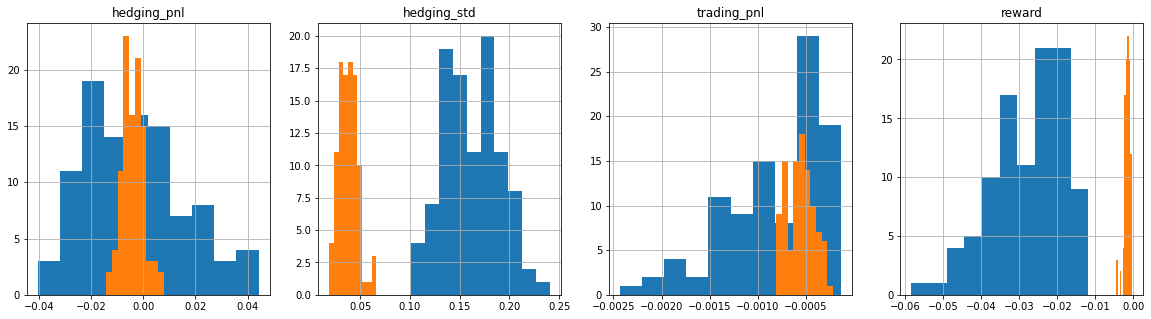

processing episode 5600


KeyboardInterrupt: 

In [5]:
num_episodes = 10001

rows = []

for episode in range(num_episodes):
    if episode % 100 == 0:
        rows = run_comparison(dqn, env)
        interpret_rows(rows)
        print(f"processing episode {episode}")
    
    done  = False
    state = env.reset()

    while not done:
        new_h                 = predict_while_training(dqn, state)
        
        new_state, pnls, done = env.step(new_h.item())
        # pnls = (heding_pnl, trading_pnl)
        
        reward                = 1e5 * (0.0005*np.sum(pnls) - np.sum(pnls)**2)

        add_to_training_set(dqn, state, new_h, new_state, reward, done)
        state                 = new_state
        
    if episode > 100:
        for k in range(int(env.max_steps)):
            train(dqn)


In [ ]:
dqn.mode